---------------------------------------------------------------------------------------------------------------------------
This tutorial relies on the example model provided by `dinsar`, which is built from real public datasets belonging to a small area near the Doñana National Park (southern Spain). The model can be accessed directly through  `dinsar.example.get_model()` and the relative paths to the data, through `dinsar.example.get_path()`.
For more information about the data sources, see the file *Data Sources.txt*, located in the same folder as this tutorial.

Fore **more information** about the use of any function, method, class o moduel, use `help` bult-in (or `?`) to acces its documentation:

`>>> help(dinsar.parts)` or press the **tabulator** key in Jupyter Notebook to access an object's methods.

---------------------------------------------------------------------------------------------------------------------------

<h1><center>Adding other database to the model</center></h1>

In this tutorial will see how to **create a database** of other nature (non piezometry or rainfall types) through the `DataBase` class and how to use **`find_element`** methods, available for all parts. The DataBase will be randomnly created, so it will be different each time is created.

In [25]:
import dinsar

## Creation of a random database
Esta base de datos imitará una base de datos formada por un conjunto de estaciones gps que miden la deformación del terreno in-situ.

In [26]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd 
import numpy as np

import random

asc_fname = dinsar.example.get_path('sentinel-Asc')
Asc = dinsar.Dataset(asc_fname, name='Asc', color='#6E3CD1', units='cm')

x1, y1, x2, y2 = Asc.gdf.total_bounds  # Database geographical limits
random_point = lambda x1, y1, x2, y2 : Point(random.uniform(x1, x2), random.uniform(y1, y2))

In [27]:
# Records creation (pandas.DataFrame):
columns, values = [i for i in 'ABCDE'], [np.random.random(60) for i in range(5)]
df_table = {i:j for i,j in zip(columns, values)}
df = pd.DataFrame(df_table, index=pd.date_range(start='2015', end='2020', freq='M'))
df = df.melt(var_name='Nombre', value_name='Valores', ignore_index=False)
df.index.name = 'Fechas'
df.reset_index(inplace=True)

In [28]:
# Spatial information creation (geopandas.GeoDataFrame)
table = {'Nombre':[i for i in 'ABCDE'],
         'geometry':[random_point(x1, y1, x2, y2) for i in range(5)]}
gdf = gpd.GeoDataFrame(table, crs=25830)

In [29]:
# Creating DataBase part and adding spatial info.
Gps = dinsar.DataBase(df, name='gps', units='cm', color='black')
Gps.append_geometry(gdf)

Geometría añadida correctamente.


<AxesSubplot:title={'center':'Visualizing some GPS stations'}, xlabel='Fechas', ylabel='Sensor (cm)'>

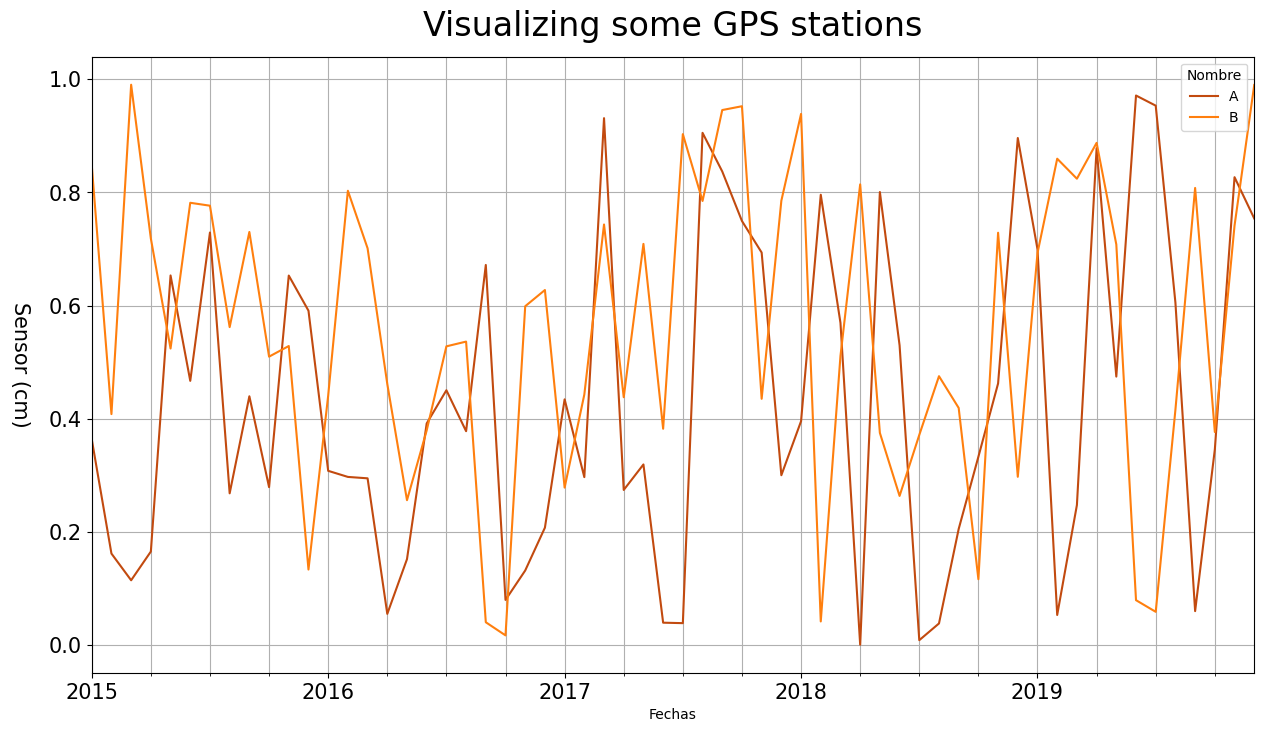

In [30]:
Gps.plot(['A','B'], title='Visualizing some GPS stations')

## Using `find_element` method with the GPS database.

Ejemplo de estudio de la deformación promedio existente a 10 km a la redonda de la estación 'A' de GPS.

Antes de nada vamos a ver en un mapa los PS del Dataset 'Asc' y las estaciones de GPS disponibles.

In [34]:
mymap = Gps.mapa(LayerControl=False)
Asc.mapa(m=mymap)

Para seleccionar los PS del dataset 'Asc' a 10 km a la redonda se necesita incluir las coordenadas del sensor 'A', las cuales las obtengo a partir del método `xy`, disponible para cualquier parte.

In [41]:
A_xy = Gps.xy('A')

Ahora uso el método `find_element` del Dataset 'Asc' y selecciono los puntos a 10 km a la redonda de la estación 'A' (`radius` can be changed if no close PS are found). Como me interesa el nombre de los puntos y no sus series temporales, utilizo el método `columns` del `DataFrame` obtenido.

In [42]:
points = Asc.find_element(A_xy, way='radius', radius=10).columns

Realizo un `subset` con los puntos obtenidos para calcular su **serie temporal de deformación promedio**, teniendo en cuenta únicamente la **componente vertical** de la deformación.

In [137]:
ts_Asc = Asc.subset(list(points), vm=True).mean()

ts_gps = Gps.take('A').loc[:,('Fechas', 'Valores')]
ts_gps = ts_gps.set_index('Fechas').squeeze()

**Visualización** conjunta del resultado.

<AxesSubplot:xlabel='Fechas'>

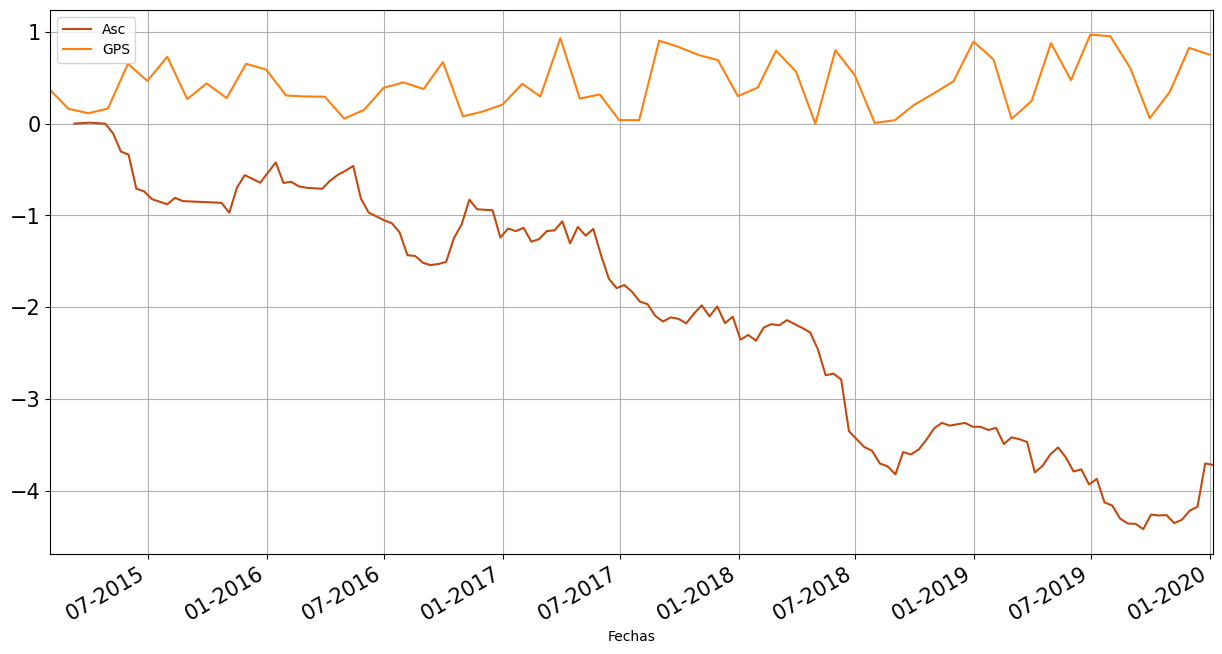

In [141]:
ax = ts_Asc.plot(label='Asc',legend=True)
ts_gps.plot(ax=ax, label='GPS',legend=True)

#### Análisis wavelet conjunto para la identificación de periodicidades comunes.

In [ ]:
dinsar.Wavelet('M', ts_Asc, ts_gps)